Temat: "Predykcja czasu osiągnięcia odporności zbiorowej w przypadku COVID-19 w grupie Wyszehradzkiej"

Zespół: Blanka Piekarz, Marcin Stachura

In [196]:
import pandas as pd
import numpy as np
import matplotlib as mtl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

df = pd.read_csv('./country_vaccinations.csv', delimiter=',')

columnsToDrop = ['iso_code', 'daily_vaccinations_raw', 'source_website', 'source_name',
                 'vaccines', 'people_fully_vaccinated_per_hundred',
                 'people_vaccinated_per_hundred', 'total_vaccinations_per_hundred']

data = df.drop(columnsToDrop, 1)
data = data[data['daily_vaccinations'].notna()]

#  ---- ADD POPULATION -----
df_population = pd.read_csv("population.csv", delimiter=',', sep=',', header=2, usecols=['Country Name', '2019'])
df_population.loc[df_population['Country Name'] == 'Slovak Republic', 'Country Name'] = 'Slovakia'

for i in range(0,len(df_population)):
    data.loc[data['country'] == df_population.loc[i, 'Country Name'], 'population'] = df_population.loc[i, '2019']

#  ---- VISEGRAD STATISTICS / FILL NaN -----
visegrad_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'Hungary', 'Poland', 'Slovakia']
visegrad_data = data[data['country'].isin(visegrad_countries)]
for i in range(0, len(visegrad_countries)):
    visegrad_data.loc[visegrad_data['country'] == visegrad_countries[i], 'country'] = i

visegrad_data = visegrad_data.reset_index(drop=True)

import datetime as dt
visegrad_data['date'] = pd.to_datetime(visegrad_data['date'])

date_column = visegrad_data['date'].copy()
country_column = visegrad_data['country'].copy()

visegrad_data = visegrad_data.fillna(visegrad_data.mean())
visegrad_data

C:\Users\Cinek\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,daily_vaccinations_per_million,population
0,0,2020-12-28,1965.0,1965.0,170010.096154,1286.0,143.0,8877067.0
1,0,2020-12-29,3578.0,3578.0,170010.096154,1450.0,161.0,8877067.0
2,0,2020-12-30,4917.0,4917.0,170010.096154,1413.0,157.0,8877067.0
3,0,2020-12-31,4925.0,4925.0,170010.096154,1062.0,118.0,8877067.0
4,0,2021-01-01,4926.0,4926.0,170010.096154,849.0,94.0,8877067.0
...,...,...,...,...,...,...,...,...
477,7,2021-03-05,517550.0,339920.0,177630.000000,11694.0,2142.0,5454073.0
478,7,2021-03-06,529538.0,349850.0,179688.000000,12448.0,2280.0,5454073.0
479,7,2021-03-07,533032.0,353152.0,179880.000000,12152.0,2226.0,5454073.0
480,7,2021-03-08,544986.0,356536.0,188450.000000,11698.0,2143.0,5454073.0


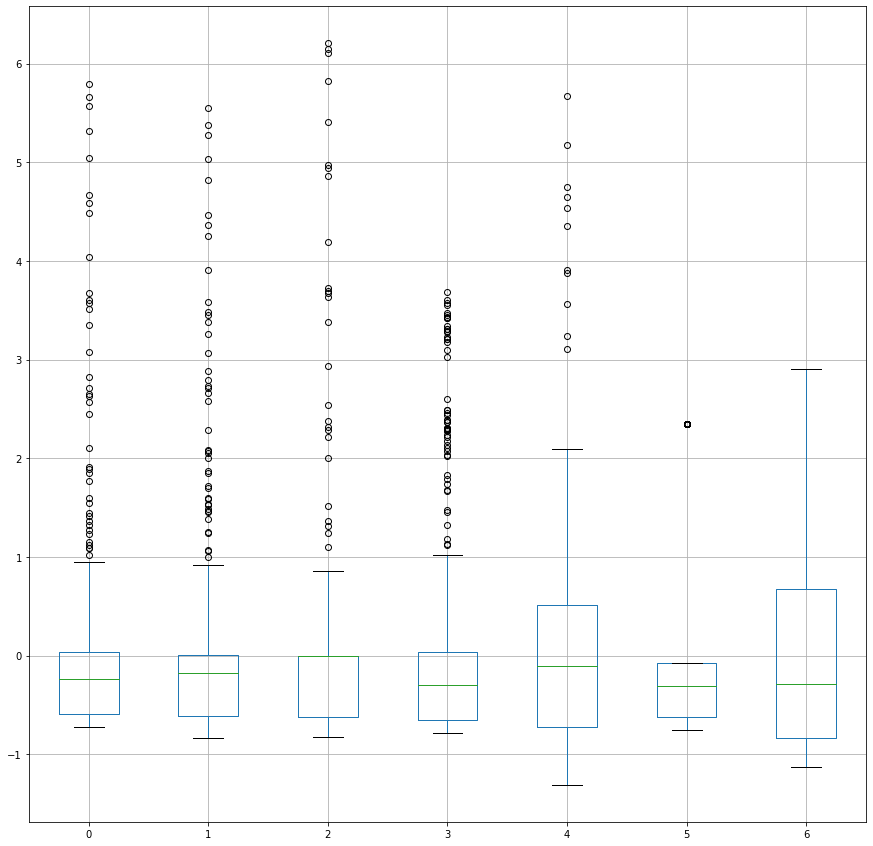

In [197]:
#  ---- STANDARDIZATION ----
visegrad_data['total_vaccinations_percentage'] = visegrad_data['total_vaccinations']/visegrad_data['population']
visegrad_data = visegrad_data.drop(['date'], 1)
visegrad_data = visegrad_data.drop(['country'], 1)


visegrad_values = visegrad_data.values
X_standard_scaler = visegrad_values - visegrad_values.mean(axis=0)
X_standard_scaler = X_standard_scaler / visegrad_values.std(axis=0)

# X_standard_scaler.hist(figsize=(30,30))
dr = pd.DataFrame(X_standard_scaler)
dr.boxplot()

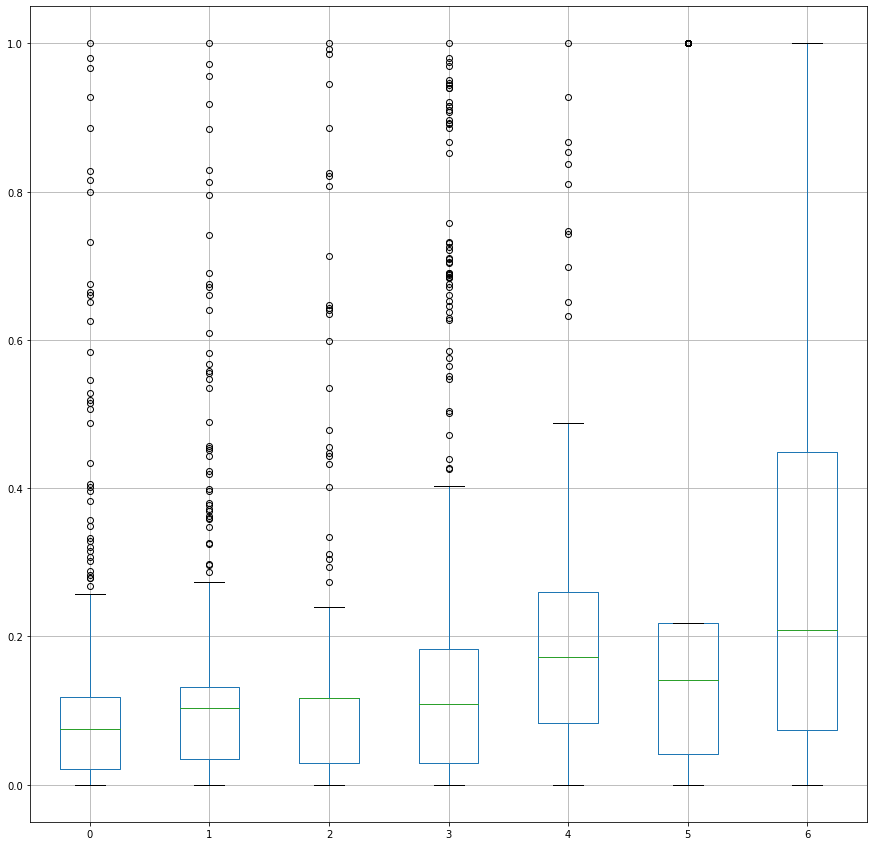

In [198]:
#  ---- STANDARDIZATION - USING SKLEARN ----
from sklearn import preprocessing

values = visegrad_data.values
min_max_scaler = preprocessing.MinMaxScaler()
data_input_scaled = min_max_scaler.fit_transform(values)
df_new = pd.DataFrame(data_input_scaled)

df_new.boxplot()

In [199]:
df_new.describe()

,0,1,2,3,4,5,6
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,0.111851,0.130157,0.117574,0.175237,0.187548,0.242927,0.280483
std,0.153596,0.156784,0.142390,0.223821,0.143363,0.322364,0.248281
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021014,0.034862,0.029068,0.029693,0.083813,0.040898,0.073796
50%,0.075006,0.103169,0.117574,0.108500,0.172171,0.141861,0.208606
75%,0.117974,0.131176,0.117574,0.182921,0.260567,0.218756,0.448458
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [200]:
from sklearn.model_selection import train_test_split

X = dr.values[:,2:]
y = dr.values[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=False)
x_ax = range(len(y_test))

In [201]:
from xgboost import XGBRegressor

xgb_clf = XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

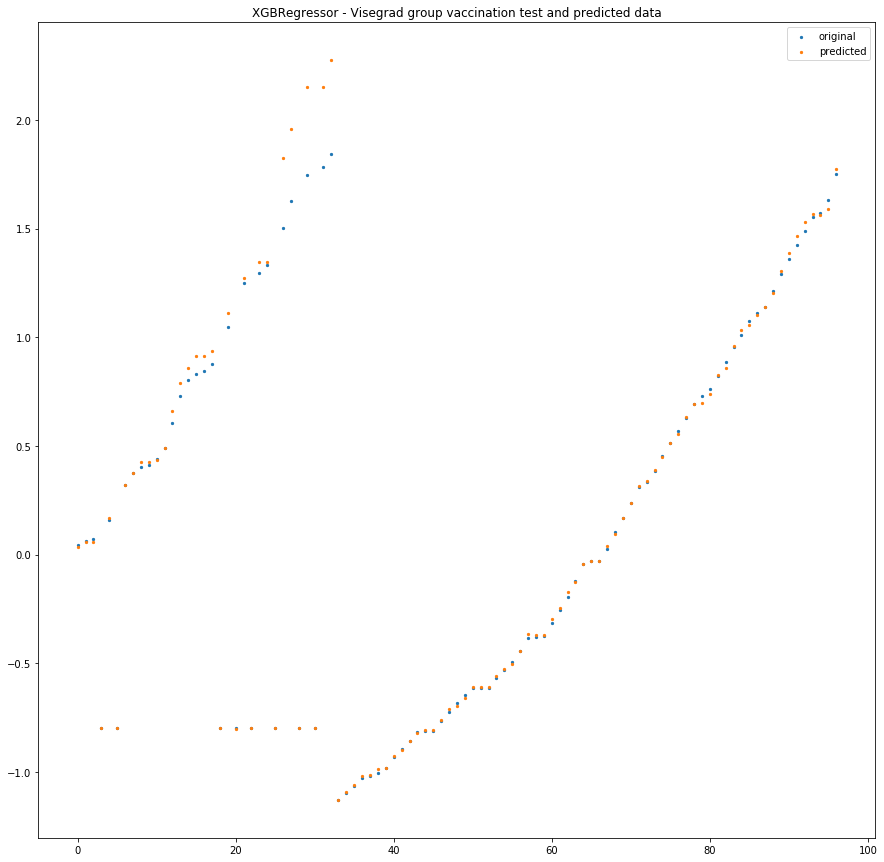

In [202]:
plt.scatter(x_ax, y_test, s=5, label="original")
plt.scatter(x_ax, y_pred_xgb, s=5, label="predicted")
plt.title("XGBRegressor - Visegrad group vaccination test and predicted data")
plt.legend()
plt.show()

In [203]:
from sklearn.svm import SVR

svr_clf = SVR()
svr_clf.fit(X_train, y_train)
y_pred_svr = svr_clf.predict(X_test)

C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


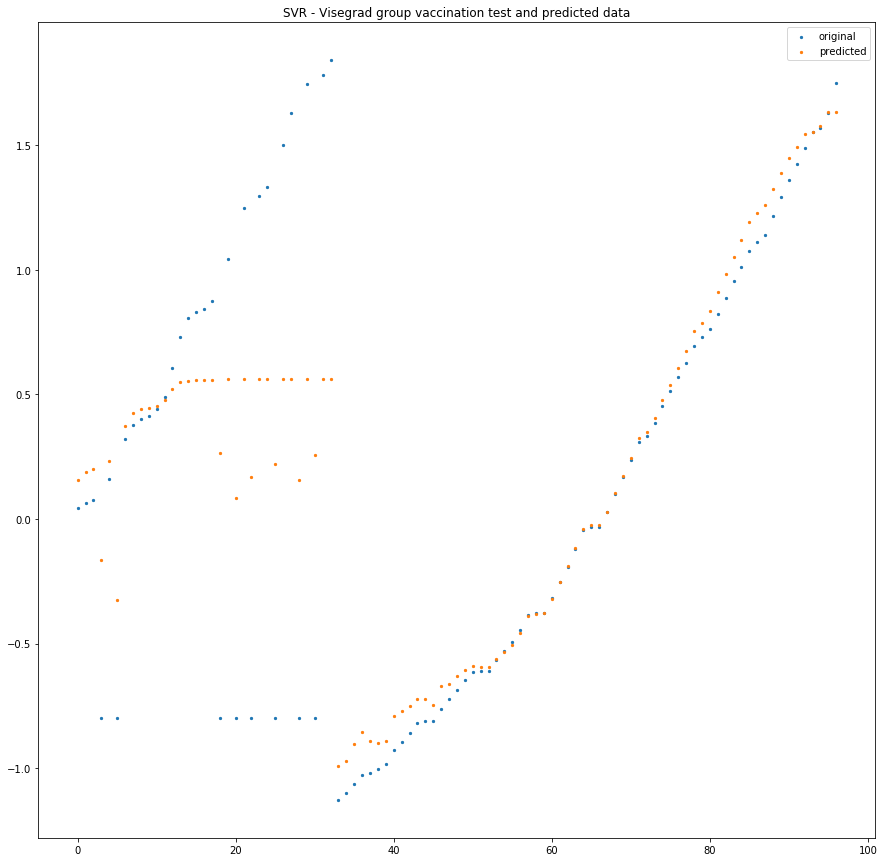

In [204]:
plt.scatter(x_ax, y_test, s=5, label="original")
plt.scatter(x_ax, y_pred_svr, s=5, label="predicted")
plt.title("SVR - Visegrad group vaccination test and predicted data")
plt.legend()
plt.show()

In [205]:
def get_r2_score(x, y):
    y_prediction = np.reshape(y, (y.shape[0], -1))
    zx = (x-np.mean(x))/np.std(x, ddof=1)
    zy = (y_prediction-np.mean(y_prediction))/np.std(y_prediction, ddof=1)
    r = np.sum(zx*zy)/(len(x)-1)
    return r**2

r2_score_xgb = get_r2_score(y_test, y_pred_xgb)
r2_score_svr = get_r2_score(y_test, y_pred_svr)

print(f'XGBRegressor score: {r2_score_xgb}')
print(f'SVR score: {r2_score_svr}')


XGBRegressor score: 0.9932990147165064
SVR score: 0.7931272279222926


In [206]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

time_series_split = TimeSeriesSplit(max_train_size=None, n_splits=10)
i = 0
for train_index, test_index in time_series_split.split(X):
    i += 1
    X_train_cross_validation, X_test_cross_validation = X[train_index], X[test_index]
    y_train_cross_validation, y_test_cross_validation = y[train_index], y[test_index]
    print(f'Iteration: {i}   Train interval: {train_index[0]}-{train_index[-1]}   Test interval: {test_index[0]}-{test_index[-1]}')


Iteration: 1   Train interval: 0-51   Test interval: 52-94
Iteration: 2   Train interval: 0-94   Test interval: 95-137
Iteration: 3   Train interval: 0-137   Test interval: 138-180
Iteration: 4   Train interval: 0-180   Test interval: 181-223
Iteration: 5   Train interval: 0-223   Test interval: 224-266
Iteration: 6   Train interval: 0-266   Test interval: 267-309
Iteration: 7   Train interval: 0-309   Test interval: 310-352
Iteration: 8   Train interval: 0-352   Test interval: 353-395
Iteration: 9   Train interval: 0-395   Test interval: 396-438
Iteration: 10   Train interval: 0-438   Test interval: 439-481


Ponieważ stosujemy szeregi czasowe, przewidywanie przeszłości za pomocą danych z przyszłości wydaje się być bez sensu. Z tego powodu stosujemy dzielenie danych na podzbiory w sposób przedstawiony na ilustracji poniżej:

https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
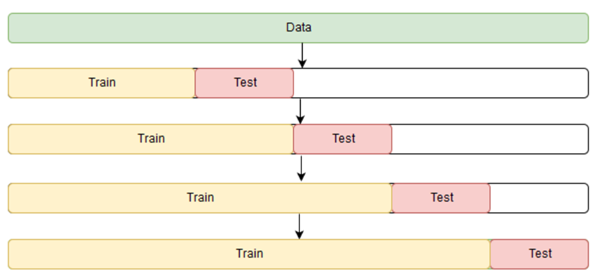

Zastosowanie powyższej walidacji krzyżowej dla poszczególnych regresorów:

In [207]:
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import neighbors
from statistics import mean
from IPython.display import HTML, display

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))
    

def svr_regression_prediction(X_train, y_train, X_test):
    svr_clf = SVR()
    svr_clf.fit(X_train, y_train)
    y_pred_svr = svr_clf.predict(X_test)
    return y_pred_svr
    
def xgb_regression_prediction(X_train, y_train, X_test):
    xgb_clf = XGBRegressor(objective="reg:squarederror", n_estimators=100)
    xgb_clf.fit(X_train, y_train)
    y_pred_xgb = xgb_clf.predict(X_test)
    return y_pred_xgb

def mlp_regression_prediction(X_train, y_train, X_test):
    mlp_clf = MLPRegressor()
    mlp_clf.fit(X_train, y_train)
    y_pred_mlp = mlp_clf.predict(X_test)
    return y_pred_mlp

def tree_regression_prediction(X_train, y_train, X_test):
    tree_clf = tree.DecisionTreeRegressor()
    tree_clf.fit(X_train, y_train)
    y_pred_tree = tree_clf.predict(X_test)
    return y_pred_tree

def k_neighbors_regression_prediction(X_train, y_train, X_test):
    isotonic_clf = neighbors.KNeighborsRegressor()
    isotonic_clf.fit(X_train, y_train)
    y_pred_isotonic = isotonic_clf.predict(X_test)
    return y_pred_isotonic

i = 0
svr_scores = []
xgb_scores = []
mlp_scores = []
tree_scores = []
k_neighbours_scores = []

for train_index, test_index in time_series_split.split(X):
    i += 1
    X_train_cross_validation, X_test_cross_validation = X[train_index], X[test_index]
    y_train_cross_validation, y_test_cross_validation = y[train_index], y[test_index]
    
    prediction_svr = svr_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation)
    r2_score_svr = get_r2_score(y_test_cross_validation, prediction_svr)
    svr_scores.append(r2_score_svr)
    
    prediction_xgb = xgb_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation)
    r2_score_xgb = get_r2_score(y_test_cross_validation, prediction_xgb)
    xgb_scores.append(r2_score_xgb)
    
    prediction_mlp = mlp_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation)
    r2_score_mlp = get_r2_score(y_test_cross_validation, prediction_mlp)
    mlp_scores.append(r2_score_mlp)
    
    prediction_tree_regression = tree_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation)
    r2_score_tree_regression = get_r2_score(y_test_cross_validation, prediction_tree_regression)
    tree_scores.append(r2_score_tree_regression)
    
    prediction_k_neighbours = k_neighbors_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation)
    r2_score_k_neighbours = get_r2_score(y_test_cross_validation, prediction_k_neighbours)
    k_neighbours_scores.append(r2_score_k_neighbours)
    

table_data = [['Regressor model', 'Average r2 score']]
table_data.append(['SVR', mean(svr_scores)])
table_data.append(['XGBRegressor', mean(xgb_scores)])
table_data.append(['MLP', mean(mlp_scores)])
table_data.append(['Decision Tree', mean(tree_scores)])
table_data.append(['K-neighbours', mean(k_neighbours_scores)])

display_table(table_data)




C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

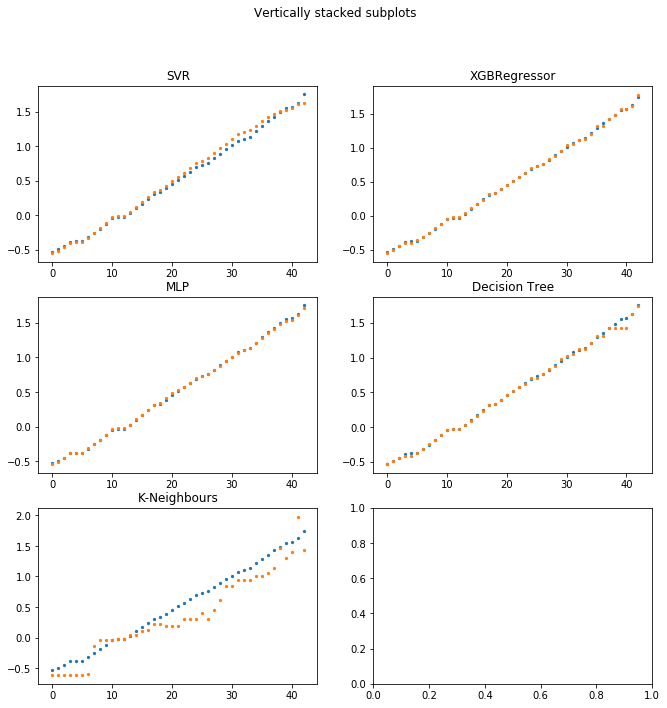

In [216]:
x_ax = range(len(y_test_cross_validation))    
mtl.rcParams['figure.figsize'] = (11,11)
fig, axs = plt.subplots(3, 2)
fig.suptitle('Vertically stacked subplots')
axs[0, 0].set_title('SVR')
axs[0, 0].scatter(x_ax, y_test_cross_validation, s=5)
axs[0, 0].scatter(x_ax, prediction_svr, s=5)
axs[0, 1].set_title('XGBRegressor')
axs[0, 1].scatter(x_ax, y_test_cross_validation, s=5)
axs[0, 1].scatter(x_ax, prediction_xgb, s=5)
axs[1, 0].set_title('MLP')
axs[1, 0].scatter(x_ax, y_test_cross_validation, s=5)
axs[1, 0].scatter(x_ax, prediction_mlp, s=5)
axs[1, 1].set_title('Decision Tree')
axs[1, 1].scatter(x_ax, y_test_cross_validation, s=5)
axs[1, 1].scatter(x_ax, prediction_tree_regression, s=5)
axs[2, 0].set_title('K-Neighbours')
axs[2, 0].scatter(x_ax, y_test_cross_validation, s=5)
axs[2, 0].scatter(x_ax, prediction_k_neighbours, s=5)